In [1]:
# Imports
import ast
import os
import math
import pandas as pd
import string
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB


from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import text2emotion as te

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/koen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/koen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/koen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2024-03-29 11:47:10.121244: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-29 11:47:10.173464: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-29 11:

True

In [10]:
csv = os.path.join(os.getcwd(), 'data', 'metadata.csv')
df = pd.read_csv(csv)
print(df.shape)
df.dropna(subset=['genre'], inplace=True)
print(df.shape)

(8052, 13)
(8049, 13)


In [11]:
df.head()

,id,type,title,genre,description,published_at,content_rating,rating_value,rating_count,duration,keywords,directors,actors
0,tt1981080,Movie,Tai ji 1: Cong ling kai shi,"['Action', 'Adventure', 'Drama']",Yang travels to Chen Village to learn a powerf...,2012-09-27,PG-13,6.0,5252.0,100.0,"['steampunk', 'steampunk fantasy', '3d', '3 di...",['Stephen Fung'],"['Hark-On Fung', 'Xiaochao Yuan', 'Stephen Fung']"
1,tt3043630,Movie,Xiao shi dai,"['Drama', 'Romance']",When four best friends try and move forward in...,2013-06-27,Not Rated,3.3,2424.0,116.0,"['friendship', 'money']",['Jingming Guo'],"['Mi Yang', 'Amber Kuo', 'Kai Ko']"
2,tt0316654,Movie,Spider-Man 2,"['Action', 'Adventure', 'Sci-Fi']",Peter Parker is beset with troubles in his fai...,2004-07-14,6,7.5,701690.0,127.0,"['spider man character', 'peter parker charact...",['Sam Raimi'],"['Tobey Maguire', 'Kirsten Dunst', 'Alfred Mol..."
3,tt0770752,Movie,Fool's Gold,"['Action', 'Adventure', 'Comedy']",A new clue to the whereabouts of a lost treasu...,2008-05-01,12,5.7,84085.0,112.0,"['treasure hunter', 'silt', 'mercenary', 'cari...",['Andy Tennant'],"['Matthew McConaughey', 'Kate Hudson', 'Donald..."
4,tt0772178,Movie,Kickin' It Old Skool,"['Comedy', 'Sport']",A young breakdancer hits his head during a tal...,2007-04-27,AL,4.6,7376.0,109.0,"['1980s', 'hospital room', 'homeless man', 'ca...",['Harvey Glazer'],"['Jamie Kennedy', 'Maria Menounos', 'Miguel A...."


#### Preprocess data

In [12]:
# Handle missing values
df['description'] = df['description'].fillna('missing')

In [13]:
df['content_rating'] = df['content_rating'].fillna('Not Rated')

content_rating_replacements = {
    'PG-13': 'Teen',
    'Not Rated': 'Unknown',
    '6': 'Child',
    '12': 'Teen',
    'AL': 'All Ages',
    'PG': 'Child',
    'R': 'Adult',
    '16': 'Adult',
    'G': 'All Ages',
    'MG6': 'Child',
    'Unrated': 'Unknown',
    '9': 'Child',
    'TV-G': 'Child',
    'TV-Y': 'All Ages',
    'T': 'Teen',
    'TV-MA': 'Adult',
    'TV-PG': 'Teen',
    '18': 'Adult',
    'TV-14': 'Adult',
    'Approved': 'All Ages',
    'NC-17': 'Adult',
    '7+': 'Child',
    '15': 'Adult',
    '14': 'Adult',
    '13+': 'Teen',
    'TV-Y7': 'Child'
}

df['content_rating'] = df['content_rating'].replace(content_rating_replacements)

unique_content_ratings = df['content_rating'].unique()
print(unique_content_ratings)

['Teen' 'Unknown' 'Child' 'All Ages' 'Adult']


In [14]:
print(df['type'].unique())

['Movie' 'TVSeries' 'VideoGame' 'TVEpisode']


In [15]:
df['duration'] = df['duration'].fillna(0)
df['published_at'] = df['published_at'].fillna(0)

In [16]:
df['genre'] = df['genre'].apply(ast.literal_eval)

# Drop the genres with less than 200 movies
DROPPABLE_GENRES = [
    'Musical',
    'News',
    'Reality-TV',
    'Short',
    'War',
    'Western',
]

mask = df['genre'].apply(lambda genres: not bool(set(genres) & set(DROPPABLE_GENRES)))

df = df[mask]
print(df.shape)

(7663, 13)


In [17]:
mlb = MultiLabelBinarizer()
genre_labels = mlb.fit_transform(df['genre'])

genre_df = pd.DataFrame(genre_labels, columns=mlb.classes_)

In [18]:
genre_df.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller
0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [19]:
print(genre_df.columns)

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller'],
      dtype='object')


In [20]:
genre_counts = genre_df.sum(axis=0)

# Convert to a DataFrame for better readability, if desired
genre_counts_df = pd.DataFrame(genre_counts, columns=['Count']).reset_index()
genre_counts_df.rename(columns={'index': 'Genre'}, inplace=True)

print(genre_counts_df)

          Genre  Count
0        Action   1552
1     Adventure   1087
2     Animation    259
3     Biography    544
4        Comedy   3188
5         Crime   1375
6   Documentary    679
7         Drama   3925
8        Family    456
9       Fantasy    477
10      History    250
11       Horror    576
12        Music    363
13      Mystery    587
14      Romance   1488
15       Sci-Fi    407
16        Sport    256
17     Thriller    965


#### Feature selection

In [21]:
# Text Vectorization
def clean_text(text):
    text = str(text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert text to lowercase

    text = text.lower()
    # Remove numbers

    text = ''.join([i for i in text if not i.isdigit()])
    # Tokenization

    tokens = word_tokenize(text)
    # Remove stopwords

    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

def get_sentiment_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_sentiment_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

features = df.copy()

# features['sentiment_polarity'] = features['description'].apply(get_sentiment_polarity)
# features['sentiment_subjectivity'] = features['description'].apply(get_sentiment_subjectivity)

features['title'].apply(clean_text)
features['description'].apply(clean_text)

vectorizer_title = TfidfVectorizer(max_features=1500)
vectorizer_description = TfidfVectorizer(max_features=5000)

X_title = vectorizer_title.fit_transform(features['title'])
X_description = vectorizer_description.fit_transform(features['description'])

encoder = OneHotEncoder()
X_type = encoder.fit_transform(features[['type']])
X_content_rating = encoder.fit_transform(features[['content_rating']])

# X_sentiment_polarity = features[['sentiment_polarity']]
# X_sentiment_subjectivity = features[['sentiment_subjectivity']]

X_duration = features[['duration']]


X_vectorized = hstack([
    X_type,
    X_content_rating,
    X_duration,
    # X_sentiment_polarity,
    # X_sentiment_subjectivity,
    X_title,
    X_description
])

#### Splitting data into training and testing

In [22]:
def partial_accuracy_score(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    matches = (y_true & y_pred).any(axis=1)

    partial_accuracy = matches.mean()
    return partial_accuracy

In [23]:
# Split the data into training and testing sets
y = genre_df
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

In [30]:
# model = MultiOutputClassifier(RandomForestClassifier(n_estimators=500, class_weight='balanced'))
# model = MultiOutputClassifier(SVC(C=10, kernel='rbf', class_weight='balanced'))
# model = MultiOutputClassifier(LogisticRegression(C=50, max_iter=5000, class_weight='balanced'))
model = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=3, weights='distance', metric='euclidean'))
# model = MultiOutputClassifier(DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=4, class_weight='balanced'))
# model = MultiOutputClassifier(GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42))
# model = MultiOutputClassifier(MultinomialNB(alpha=0.5))
# model = MultiOutputClassifier(BernoulliNB(alpha=0.5, binarize=0.5))
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

score = partial_accuracy_score(y_test, y_pred)
print(f"Partial Accuracy Score: {score}")

f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=1)
print(f'F1 Score (Micro): {f1_micro}')

f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=1)
print(f'F1 Score (Macro): {f1_macro}')

Partial Accuracy Score: 0.6086105675146771
F1 Score (Micro): 0.3663062772309182
F1 Score (Macro): 0.19310578736267256


In [71]:
n_labels = y_test.shape[1]
label_names = genre_df.columns
y_test_np = np.array(y_test)
y_pred_np = np.array(y_pred)


for i in range(n_labels):
    print(f"Classification Report for {label_names[i]}:")
    # Now using y_test_np and y_pred_np for indexing
    print(classification_report(
        y_test_np[:, i],
        y_pred_np[:, i],
        target_names=[f'Not {label_names[i]}', label_names[i]],
        labels=[0, 1],
        zero_division=1
    ))
    print("\n")

Classification Report for Action:
              precision    recall  f1-score   support

  Not Action       0.90      0.92      0.91      1230
      Action       0.65      0.58      0.62       303

    accuracy                           0.86      1533
   macro avg       0.78      0.75      0.76      1533
weighted avg       0.85      0.86      0.85      1533



Classification Report for Adventure:
               precision    recall  f1-score   support

Not Adventure       0.91      0.96      0.94      1311
    Adventure       0.66      0.45      0.53       222

     accuracy                           0.89      1533
    macro avg       0.78      0.71      0.74      1533
 weighted avg       0.87      0.89      0.88      1533



Classification Report for Animation:
               precision    recall  f1-score   support

Not Animation       0.97      1.00      0.98      1480
    Animation       0.67      0.26      0.38        53

     accuracy                           0.97      1533
    ma

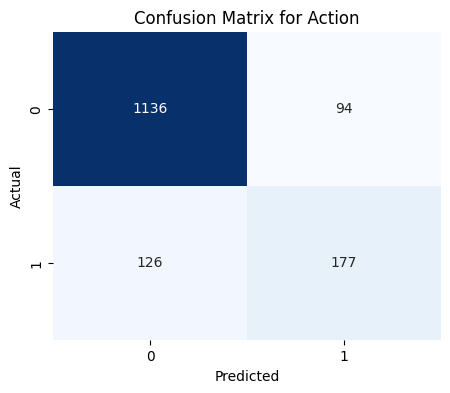

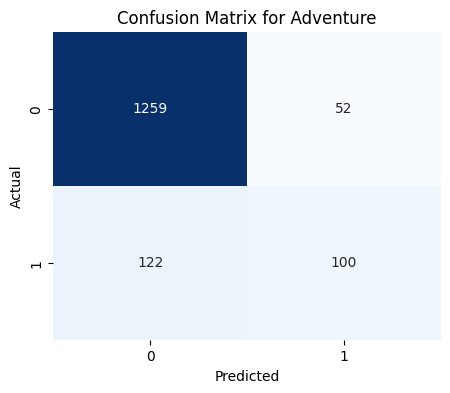

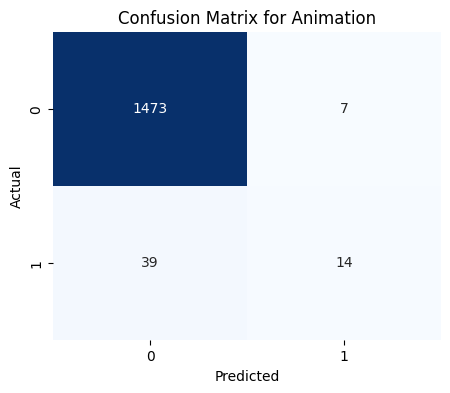

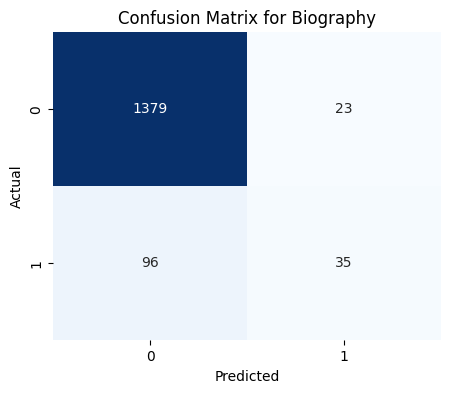

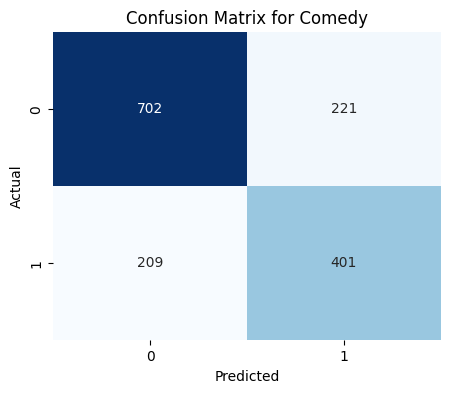

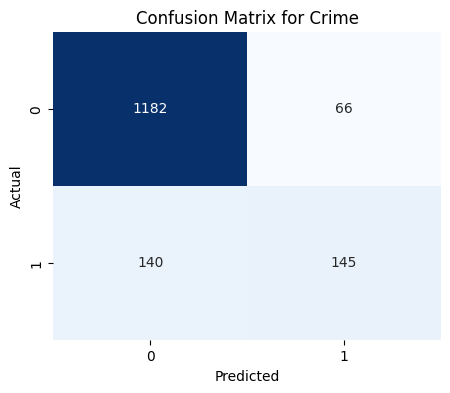

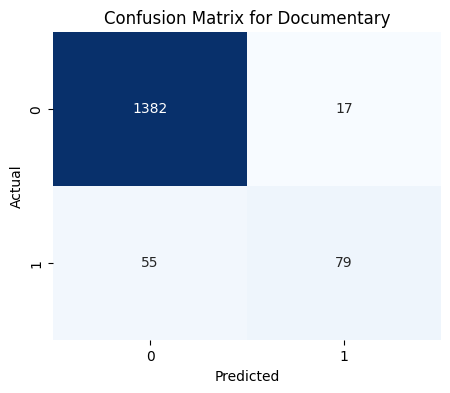

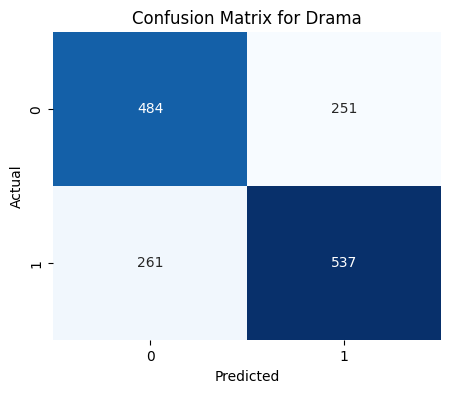

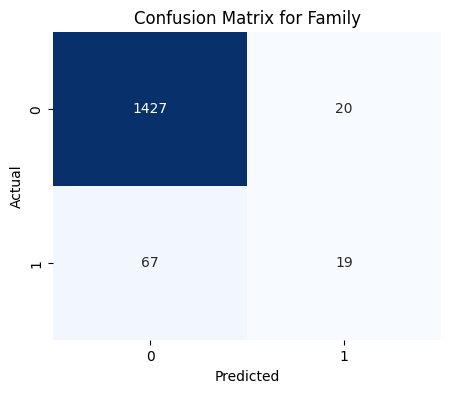

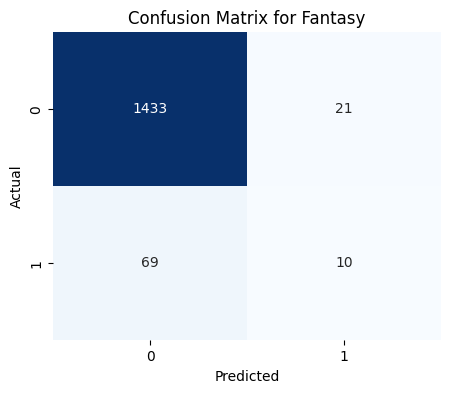

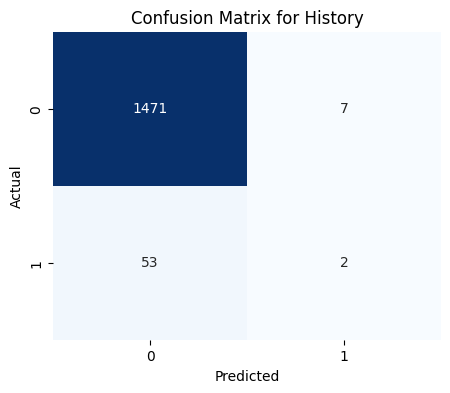

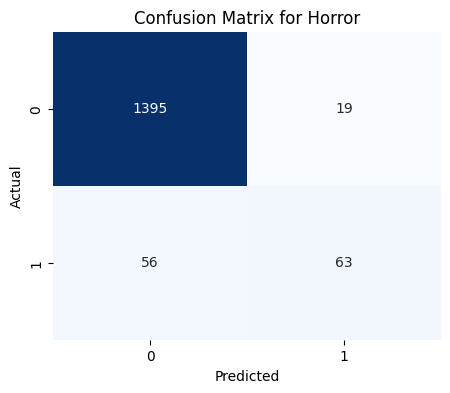

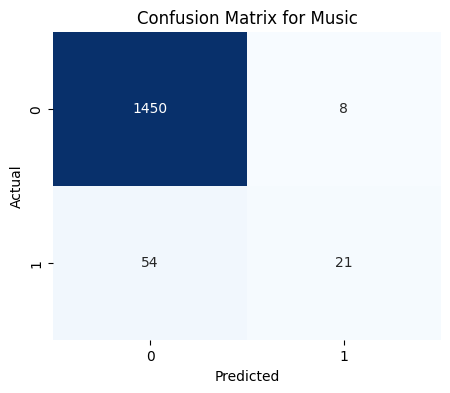

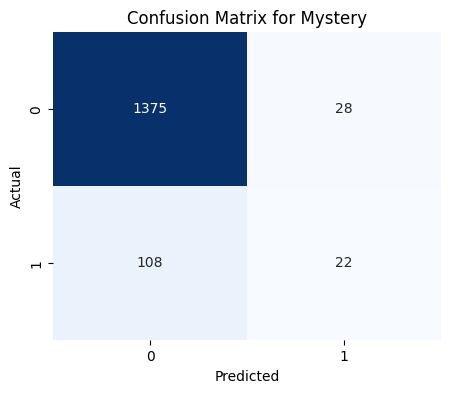

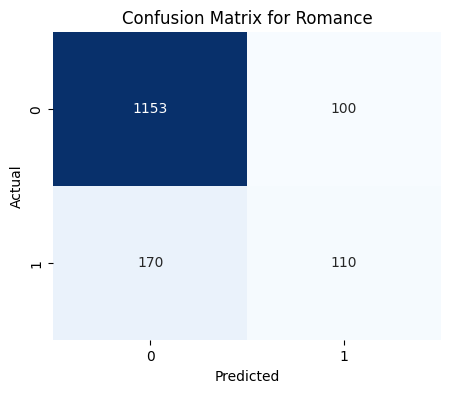

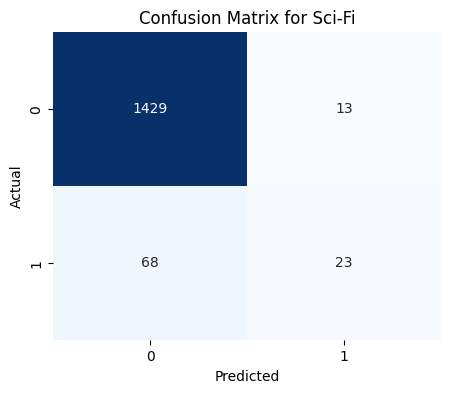

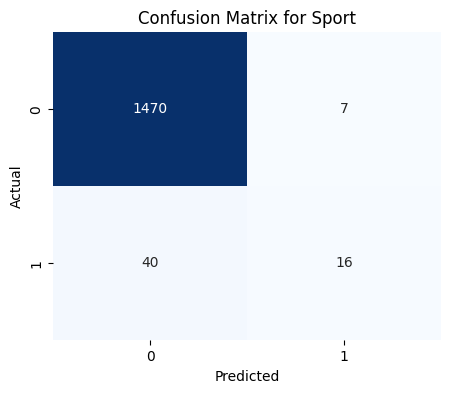

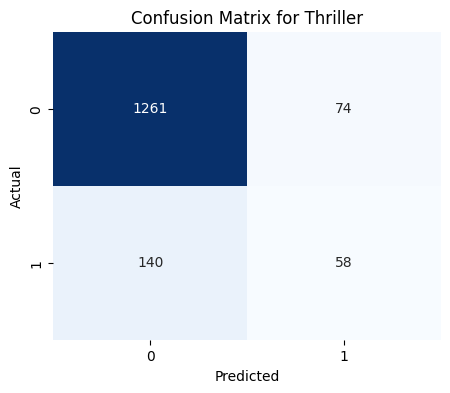

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrices = []

for i in range(n_labels):
    cm = confusion_matrix(y_test_np[:, i], y_pred_np[:, i])
    confusion_matrices.append(cm)

for i, cm in enumerate(confusion_matrices):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {label_names[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

#### Model Training

In [45]:
models_and_parameters = {
    'MultiOutput_RandomForestClassifier': {
        'model': MultiOutputClassifier(RandomForestClassifier(random_state=42)),
        'params': {
            'estimator__n_estimators': [10, 50, 100],
            'estimator__max_depth': [None, 10, 20, 30],
            'estimator__class_weight': [None, 'balanced', 'balanced_subsample']
        }
    },
    'MultiOutput_SVC': {
        'model': MultiOutputClassifier(SVC(random_state=42, probability=True)),
        'params': {
            'estimator__C': [0.1, 1, 10, 20],
            'estimator__kernel': ['rbf', 'linear'],
            'estimator__class_weight': [None, 'balanced']
        }
    },
    'MultiOutput_LogisticRegression': {
        'model': MultiOutputClassifier(LogisticRegression(random_state=42)),
        'params': {
            'estimator__C': [0.1, 1, 10, 20],
            'estimator__class_weight': [None, 'balanced']
        }
    },
    'MultiOutput_KNeighborsClassifier': {
        'model': MultiOutputClassifier(KNeighborsClassifier()),
        'params': {
            'estimator__n_neighbors': [3, 5, 10],
            'estimator__weights': ['uniform', 'distance'],
            'estimator__metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    'MultiOutput_DecisionTreeClassifier': {
        'model': MultiOutputClassifier(DecisionTreeClassifier(random_state=42)),
        'params': {
            'estimator__max_depth': [None, 10, 20, 30],
            'estimator__min_samples_split': [2, 5, 10],
            'estimator__min_samples_leaf': [1, 2, 4],
            'estimator__class_weight': [None, 'balanced']
        }
    },
    'MultiOutput_GradientBoostingClassifier': {
        'model': MultiOutputClassifier(GradientBoostingClassifier(random_state=42)),
        'params': {
            'estimator__n_estimators': [100, 200],
            'estimator__learning_rate': [0.01, 0.1, 0.2],
            'estimator__max_depth': [3, 5, 10]
        }
    },
    'MultiOutput_MultinomialNB': {
        'model': MultiOutputClassifier(MultinomialNB()),
        'params': {
            'estimator__alpha': [0.1, 0.5, 1.0, 2.0],
        }
    },
    'MultiOutput_BernoulliNB': {
        'model': MultiOutputClassifier(BernoulliNB()),
        'params': {
            'estimator__alpha': [0.1, 0.5, 1.0, 2.0],
            'estimator__binarize': [0.0, 0.5, 1.0]
        }
    }
}

In [46]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
f1_scorer = make_scorer(f1_score, average='micro')
results = []

for model_name, mp in models_and_parameters.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=cv, scoring=f1_scorer, return_train_score=False)
    clf.fit(X_train, y_train)
    results.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [38]:
# cv = KFold(n_splits=5, random_state=42, shuffle=True)

# f1_scorer = make_scorer(f1_score, average='micro')

# scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer)


# print("Accuracy scores for each fold:", scores)
# print("Mean cross-validation accuracy:", np.mean(scores))

Accuracy scores for each fold: [0.41249446 0.42259049 0.41483097 0.41837179 0.42588997]
Mean cross-validation accuracy: 0.4188355363926114


#### Evaluation

In [48]:
for result in results:
    print(result)

{'model': 'MultiOutput_RandomForestClassifier', 'best_score': 0.4166707569483005, 'best_params': {'estimator__max_depth': None, 'estimator__n_estimators': 100}}
{'model': 'MultiOutput_SVC', 'best_score': 0.47595189448016073, 'best_params': {'estimator__C': 10, 'estimator__kernel': 'rbf'}}
{'model': 'MultiOutput_LogisticRegression', 'best_score': 0.48764225088397256, 'best_params': {'estimator__C': 10}}


In [26]:
# y_pred = model.predict(X_test)
# Since this is multi-label classification, consider using other metrics as well
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.09316770186335403


#### Predictions

In [27]:
def predict_genre(description):
    desc_vectorized = vectorizer.transform([description])
    preds = model.predict(desc_vectorized)
    return mlb.inverse_transform(preds)

description = "Two friends embark on a quest for a lost treasure."

print(predict_genre(description))

[('Adventure', 'Comedy')]
